# Tennis Action Evaluator

## Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.255  train_ave_acc: 0.558  (3.69s - 733.65s remaining) ave_loss: 0.25453244737428654 ave_acc: 0.5576873647930823
EPOCH: 2.000  train_ave_loss: 0.245  train_ave_acc: 0.575  (7.03s - 695.98s remaining) ave_loss: 0.24514182112958074 ave_acc: 0.5745868865046306
EPOCH: 3.000  train_ave_loss: 0.240  train_ave_acc: 0.607  (10.39s - 682.47s remaining) ave_loss: 0.23972937300844976 ave_acc: 0.6067156398347194
EPOCH: 4.000  train_ave_loss: 0.241  train_ave_acc: 0.598  (13.72s - 672.21s remaining) ave_loss: 0.24148096618327228 ave_acc: 0.5976627421995361
EPOCH: 5.000  train_ave_loss: 0.235  train_ave_acc: 0.612  (17.04s - 664.65s remaining) ave_loss: 0.23461391246956814 ave_acc: 0.6119688099050931
EPOCH: 6.000  train_ave_loss: 0.233  train_ave_acc: 0.612  (20.38s - 658.80s remaining) ave_loss: 0.23250623853587685 ave_acc: 0.6121189076721898
EPOCH: 7.000  train_ave_loss: 0.229  train_ave_acc: 0.622  (23.72s - 654.12s remaining) ave_loss: 0.22944747450928096 ave_acc:

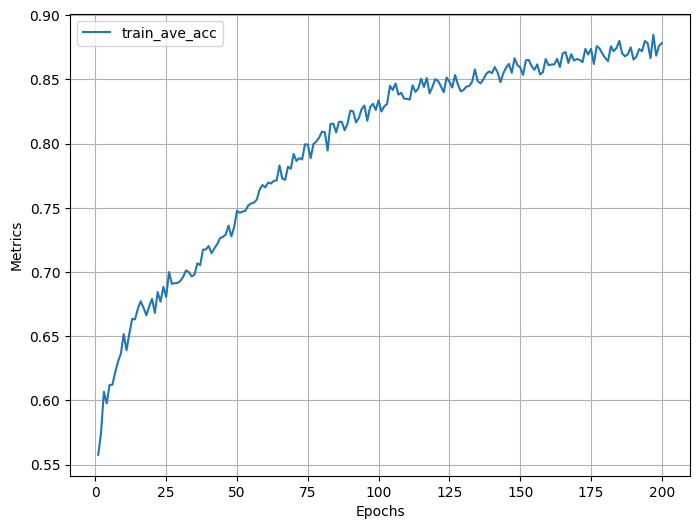

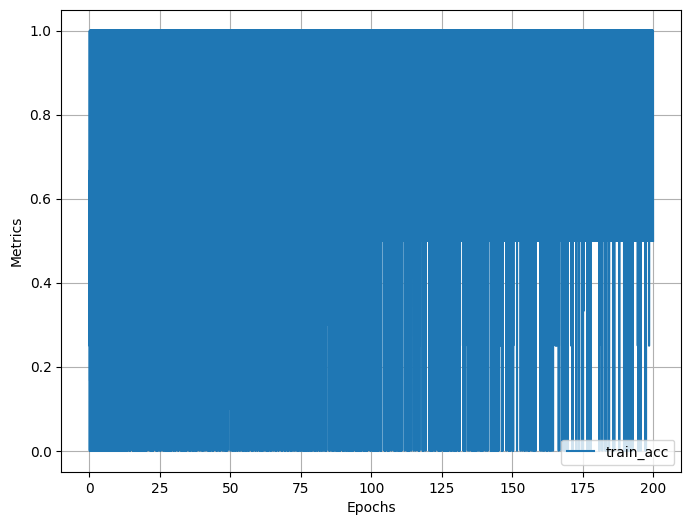

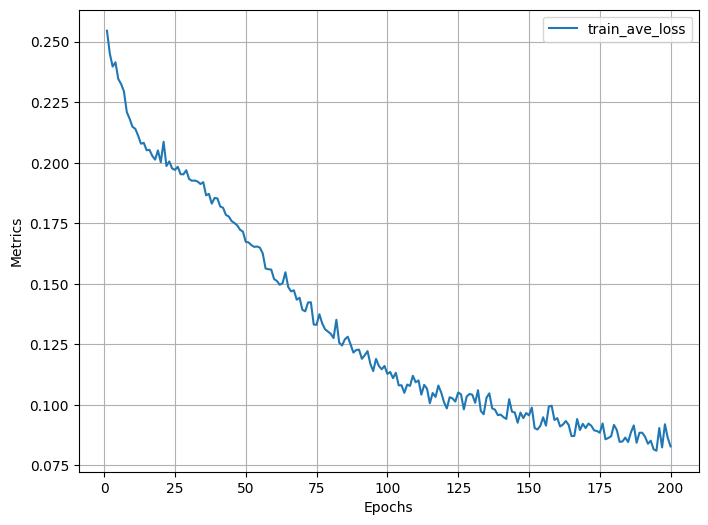

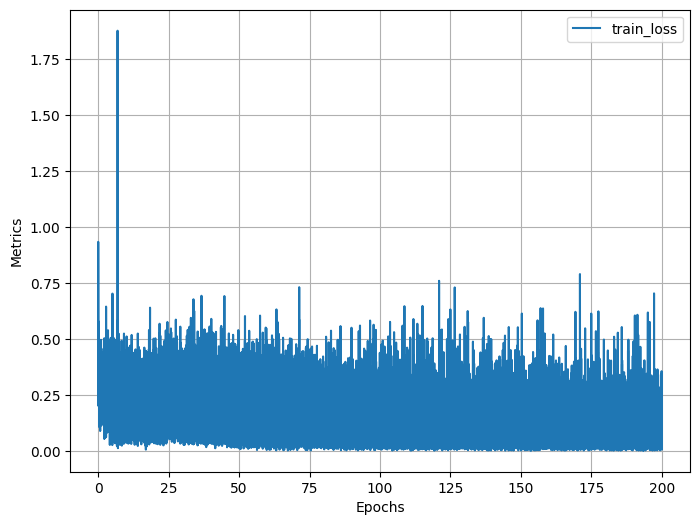

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5536159600997507
NN MC MSE: 0.34627622867741736
NN MC Seq Accuracy: 0.6309226932668329
NN MC Seq MSE: 0.30218070595987684


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.172  train_ave_acc: 0.510  (3.76s - 747.31s remaining) ave_loss: 0.1721895377744328 ave_acc: 0.509993581215992
EPOCH: 2.000  train_ave_loss: 0.139  train_ave_acc: 0.532  (7.37s - 729.64s remaining) ave_loss: 0.13891183610601335 ave_acc: 0.5319496138775734
EPOCH: 3.000  train_ave_loss: 0.133  train_ave_acc: 0.520  (11.34s - 744.86s remaining) ave_loss: 0.13338930772131313 ave_acc: 0.5200422818294018
EPOCH: 4.000  train_ave_loss: 0.132  train_ave_acc: 0.518  (15.12s - 740.84s remaining) ave_loss: 0.13168801011686976 ave_acc: 0.5181451473048306
EPOCH: 5.000  train_ave_loss: 0.128  train_ave_acc: 0.532  (18.56s - 723.78s remaining) ave_loss: 0.12755451816246133 ave_acc: 0.5320135025661141
EPOCH: 6.000  train_ave_loss: 0.128  train_ave_acc: 0.525  (21.96s - 710.01s remaining) ave_loss: 0.12838319273900425 ave_acc: 0.5253271567669101
EPOCH: 7.000  train_ave_loss: 0.109  train_ave_acc: 0.565  (25.42s - 700.81s remaining) ave_loss: 0.10949613892710891 ave_acc: 0

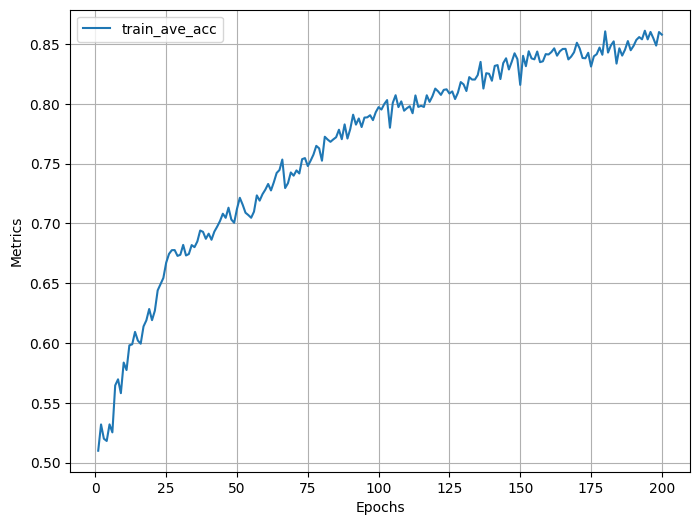

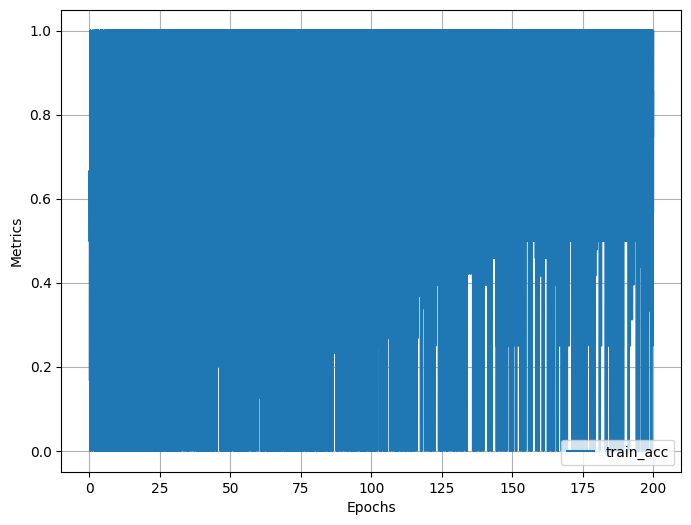

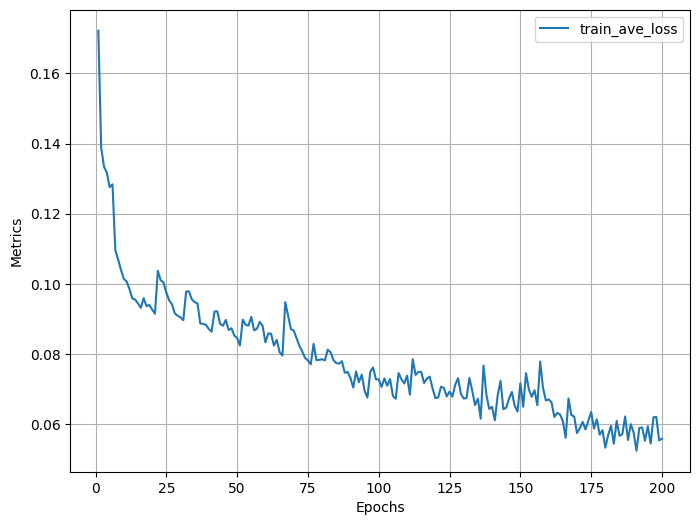

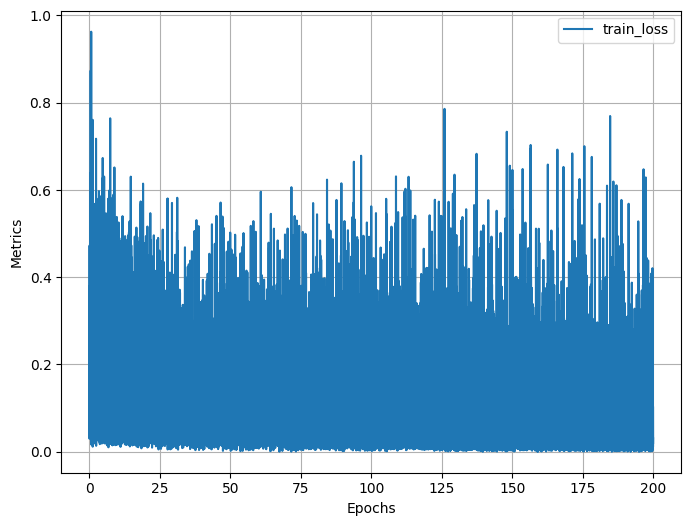

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5648379052369077
NN Sarsa MSE: 0.2958725654874987
NN Sarsa Seq Accuracy: 0.6783042394014963
NN Sarsa Seq MSE: 0.2409910671866012


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.080  train_ave_acc: 0.863  (4.57s - 909.69s remaining) ave_loss: 0.07985711508345875 ave_acc: 0.8630434071147057
EPOCH: 2.000  train_ave_loss: 0.080  train_ave_acc: 0.861  (8.40s - 831.53s remaining) ave_loss: 0.07968944105418001 ave_acc: 0.860701880310492
EPOCH: 3.000  train_ave_loss: 0.080  train_ave_acc: 0.855  (11.86s - 779.13s remaining) ave_loss: 0.07970098673712184 ave_acc: 0.855054615603187
EPOCH: 4.000  train_ave_loss: 0.076  train_ave_acc: 0.864  (15.14s - 741.92s remaining) ave_loss: 0.07597869761080599 ave_acc: 0.8636446395864731
EPOCH: 5.000  train_ave_loss: 0.083  train_ave_acc: 0.847  (18.41s - 718.04s remaining) ave_loss: 0.08302985423290965 ave_acc: 0.8471607075378319
EPOCH: 6.000  train_ave_loss: 0.078  train_ave_acc: 0.851  (22.49s - 727.32s remaining) ave_loss: 0.07756679127801243 ave_acc: 0.851339679151014
EPOCH: 7.000  train_ave_loss: 0.088  train_ave_acc: 0.849  

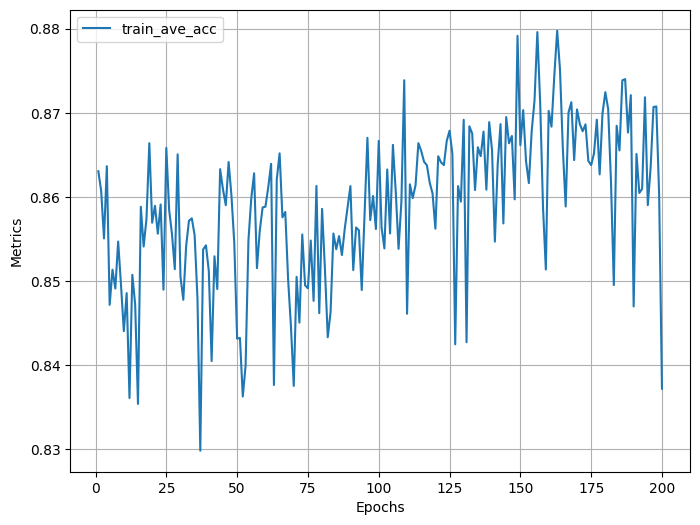

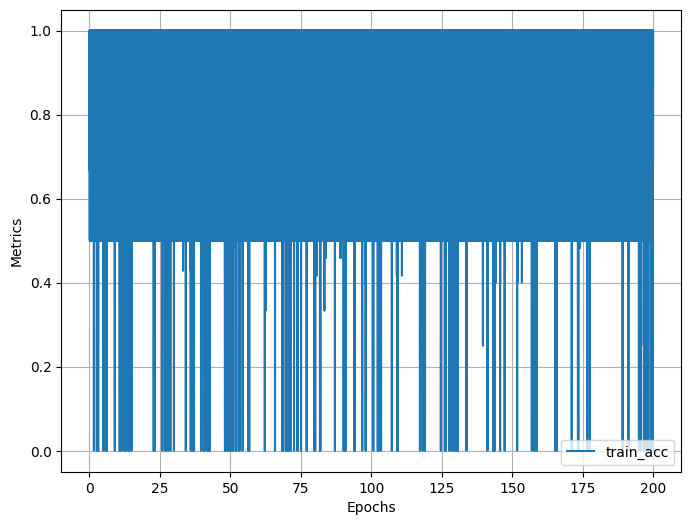

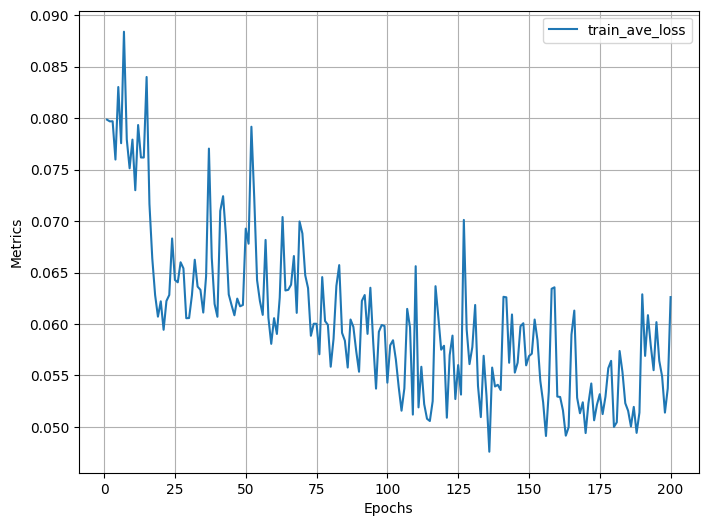

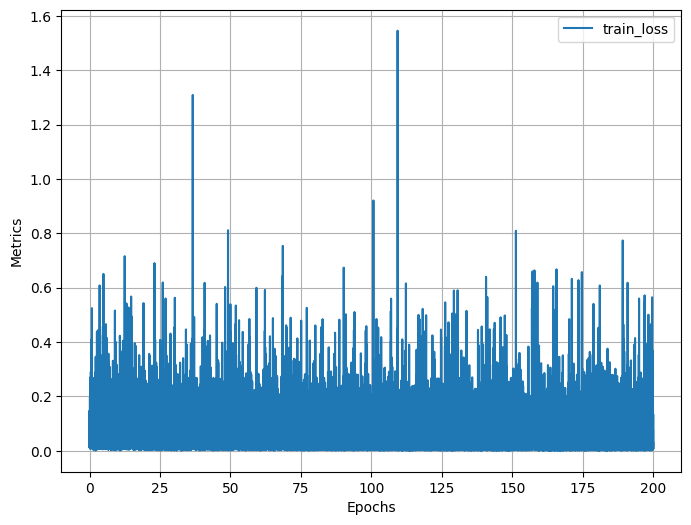

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.543640897755611
NN Sarsa With MC Init MSE: 0.3545145281233995
NN Sarsa With MC Init Seq Accuracy: 0.5972568578553616
NN Sarsa With MC Init Seq MSE: 0.3103424301712281


In [12]:
import os

model_dirpath = 'experiment_models/200epoch_e-3lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Results

===== Train Dataset =====
Summary metrics:
    Rally count: 341
    Trials count: 682
    Total shot count: 3426


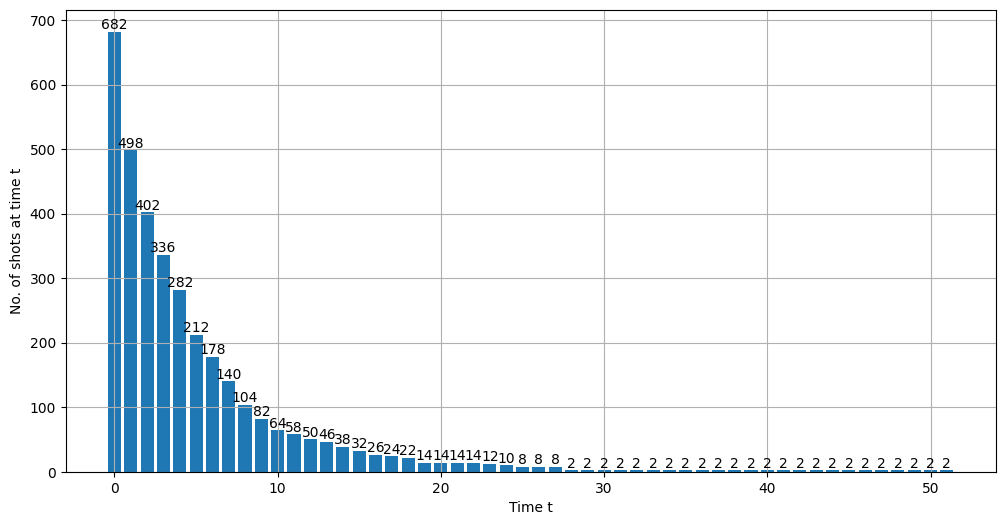


===== Test Dataset =====
Summary metrics:
    Rally count: 86
    Trials count: 172
    Total shot count: 802


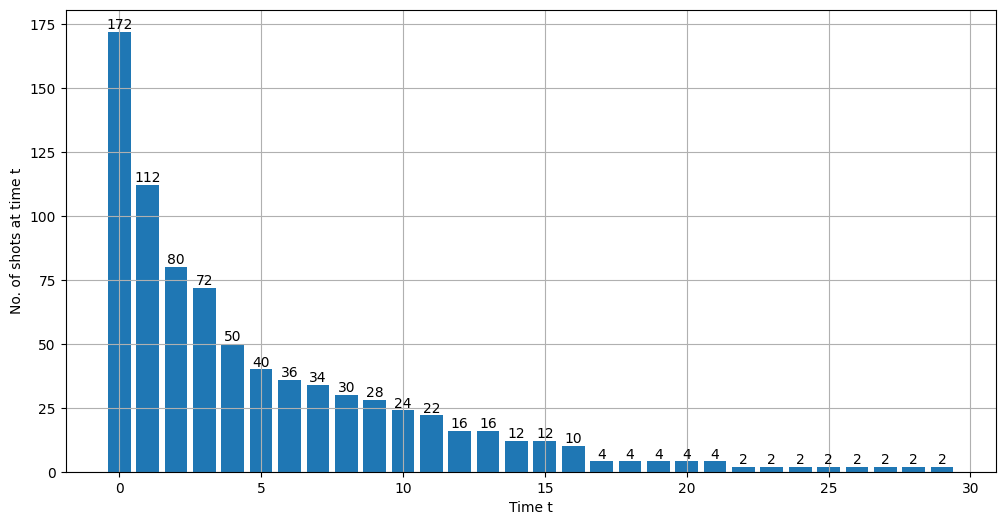

In [1]:
import evaluation as eval
from data import train_dataset, test_dataset

print("===== Train Dataset =====")
eval.plot_stroke_distribution(train_dataset)
print()
print("===== Test Dataset =====")
eval.plot_stroke_distribution(test_dataset)

In [2]:
import os
import mc_learning as mc
import d_sarsa as drl
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dirpath = 'experiment_models/200epoch_e-3lr_vanilla_paper_params'

mc_model = mc.train(save=False)
print(mc_model.coef_)

nn_mc_model = drl.TennisEvalNN().to(device)
nn_mc_model.load_state_dict(torch.load(os.path.join(model_dirpath, 'nn_mc_model.pth')))
nn_mc_model.eval()

nn_sarsa_model = drl.TennisEvalNN().to(device)
nn_sarsa_model.load_state_dict(torch.load(os.path.join(model_dirpath, 'nn_sarsa_model.pth')))
nn_sarsa_model.eval()

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


TennisEvalNN(
  (lstm): LSTM(17, 512, batch_first=True)
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1000, bias=True)
  (linear3): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
)

#### MC Linear

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

mc_win_plot, mc_lose_plot = eval.get_ave_stroke_q_per_rally(test_dataset, mc_predict, use_seq=False)

def mc_seq_predict(sa_pair):
    pred = mc_model.predict(sa_pair)
    return pred

mc_win_seq_plot, mc_lose_seq_plot = eval.get_ave_stroke_q_per_rally(test_dataset, mc_seq_predict, use_seq=True)

One-by-one:


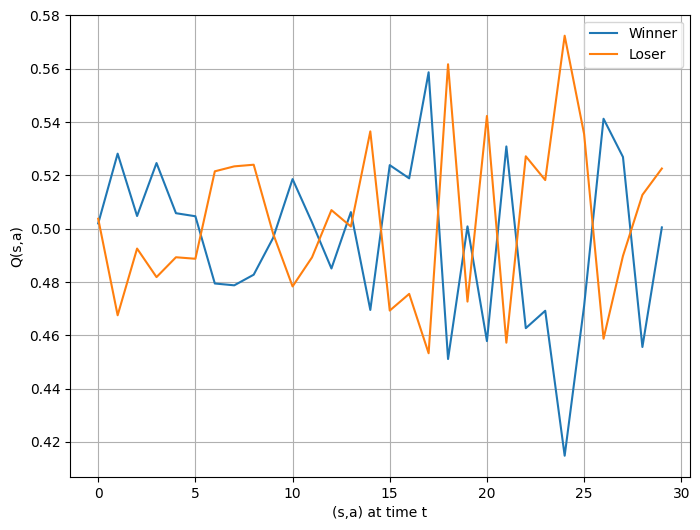

Sequential:


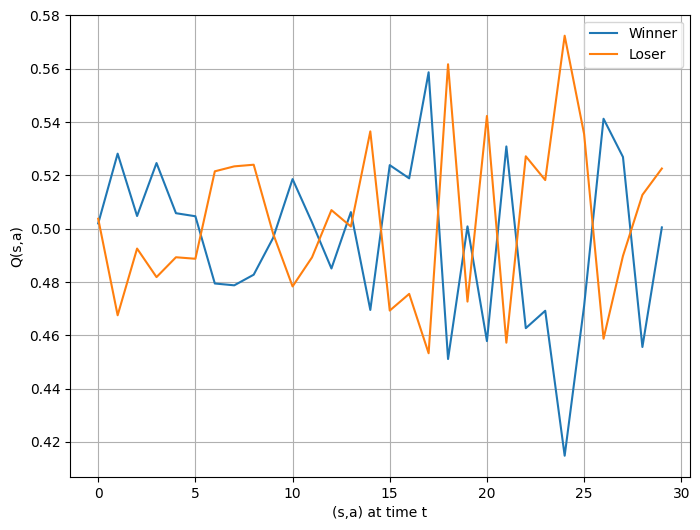

In [3]:
print("One-by-one:")
eval.plot_ave_stroke_q_per_rally(mc_win_plot, mc_lose_plot)

print("Sequential:")
eval.plot_ave_stroke_q_per_rally(mc_win_seq_plot, mc_lose_seq_plot)

### DRL - MC Learning

In [4]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_win_plot, nn_mc_lose_plot = eval.get_ave_stroke_q_per_rally(test_dataset, nn_mc_predict, use_seq=False)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_win_seq_plot, nn_mc_lose_seq_plot = eval.get_ave_stroke_q_per_rally(test_dataset, nn_mc_predict_seq, use_seq=True)

One-by-one:


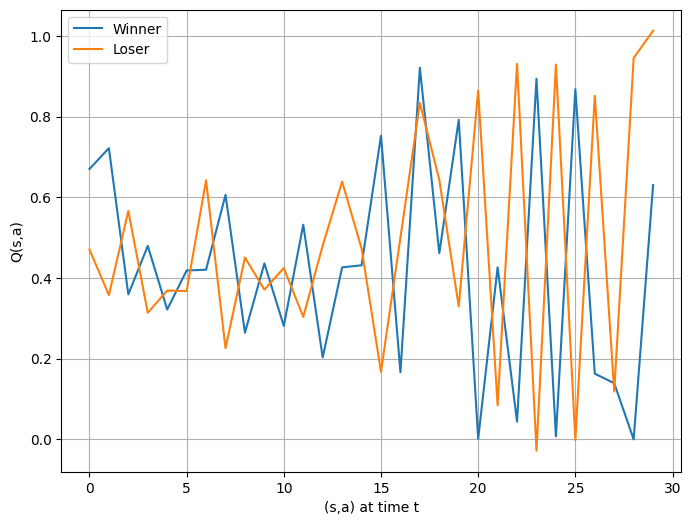

Sequential:


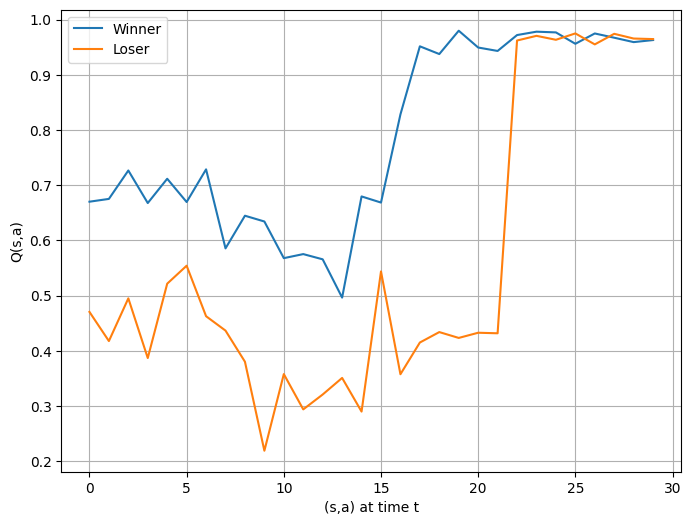

In [5]:
print("One-by-one:")
eval.plot_ave_stroke_q_per_rally(nn_mc_win_plot, nn_mc_lose_plot)

print("Sequential:")
eval.plot_ave_stroke_q_per_rally(nn_mc_win_seq_plot, nn_mc_lose_seq_plot)

### DRL - SARSA

In [6]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_sarsa_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_win_plot, nn_sarsa_lose_plot = eval.get_ave_stroke_q_per_rally(test_dataset, nn_sarsa_predict, use_seq=False)

def nn_sarsa_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_win_seq_plot, nn_sarsa_lose_seq_plot = eval.get_ave_stroke_q_per_rally(test_dataset, nn_sarsa_predict_seq, use_seq=True)

One-by-one:


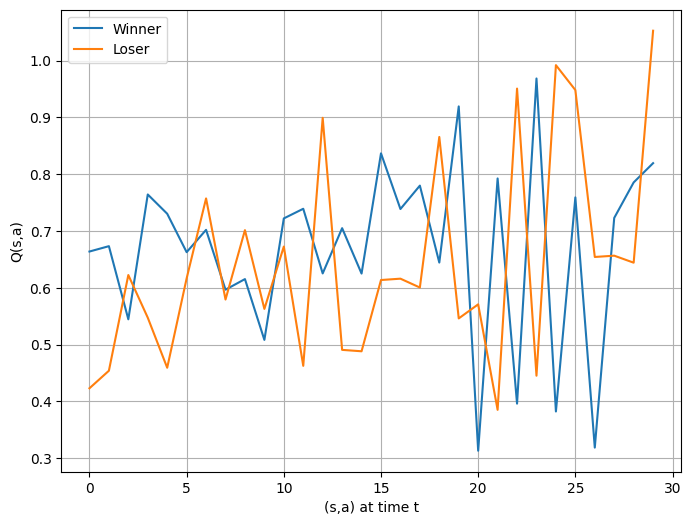

Sequential:


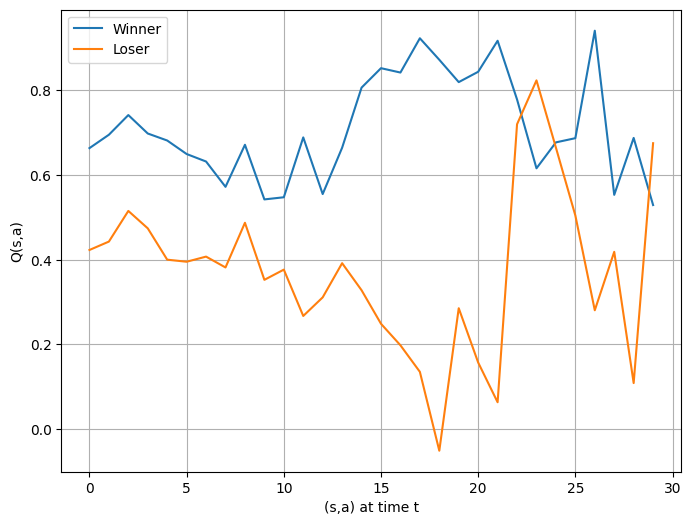

In [7]:
print("One-by-one:")
eval.plot_ave_stroke_q_per_rally(nn_sarsa_win_plot, nn_sarsa_lose_plot)

print("Sequential:")
eval.plot_ave_stroke_q_per_rally(nn_sarsa_win_seq_plot, nn_sarsa_lose_seq_plot)